In [27]:
import numpy as np
import os 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from openpyxl import Workbook

import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [28]:
def write_dict_to_excel(data_dict, filename):
    workbook = Workbook()

    worksheet = workbook.active

    headers = list(data_dict.keys())
    worksheet.append(headers)

    values = list(data_dict.values())
    worksheet.append(values)

    workbook.save(filename)

In [29]:
df_reward = pd.read_excel('reward_quest.xlsx')
df_punish = pd.read_excel('punishment_quest.xlsx')
df_mixed = pd.read_excel('mixed_quest.xlsx')
df_p_memory1 = pd.read_csv('punishment_memory_summary.csv')
df_r_memory1 = pd.read_csv('reward_memory_summary.csv')
df_m_memory1 = pd.read_csv('mixed_memory_summary.csv')
df_hddm_m = pd.read_csv('mixed_hddm_stats.csv')
df_hddm_r = pd.read_csv('reward_hddm_stats.csv')
df_hddm_p = pd.read_csv('punish_hddm_stats.csv')

In [30]:
df_p_memory1['rt'] = pd.to_numeric(df_p_memory1['rt'], errors='coerce')
df_p_memory1 = df_p_memory1.dropna(subset=['rt'])
df_r_memory1['rt'] = pd.to_numeric(df_r_memory1['rt'], errors='coerce')
df_r_memory1 = df_r_memory1.dropna(subset=['rt'])
df_m_memory1['rt'] = pd.to_numeric(df_m_memory1['rt'], errors='coerce')
df_m_memory1 = df_m_memory1.dropna(subset=['rt'])

df_m_memory1['meta'] = 1 - (df_m_memory1['accuracy'] - df_m_memory1['confidence']/100)**2
df_r_memory1['meta'] = 1 - (df_r_memory1['accuracy'] - df_r_memory1['confidence']/100)**2
df_p_memory1['meta'] = 1 - (df_p_memory1['accuracy'] - df_p_memory1['confidence']/100)**2

In [31]:
df_r_memory = df_r_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

df_m_memory = df_m_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

df_p_memory = df_p_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

In [32]:
sub_list_reward = df_r_memory['subject_nr'].unique()
cond_list_reward = df_r_memory['condition'].unique()
stage_list_reward = df_r_memory['stage'].unique()

sub_list_punishment = df_p_memory['subject_nr'].unique()
cond_list_punishment = df_p_memory['condition'].unique()
stage_list_punishment = df_p_memory['stage'].unique()

sub_list_mixed = df_m_memory['subject_nr'].unique()
cond_list_mixed= df_m_memory['condition'].unique()
stage_list_mixed= df_m_memory['stage'].unique()

In [33]:
df_hddm_m.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_r.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_p.rename(columns={'Unnamed: 0':'V1'}, inplace=True)

In [34]:
def get_hddm_para(ddm_results,subList):
    v_former_diff = ddm_results[ddm_results['V1'].str.contains("v_former_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_ses = ddm_results[ddm_results['V1'].str.contains("v_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_former_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_former_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff = ddm_results[ddm_results['V1'].str.contains("v_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    a_ses = ddm_results[ddm_results['V1'].str.contains("a_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    z_ses = ddm_results[ddm_results['V1'].str.contains("z_ses_subj")][['mean', 'V1']].reset_index(drop=True)

    # Combine the data
    ddm_params = pd.concat([
        v_former_diff[['mean']], 
        v_ses[['mean']], 
        v_former_diff_ses[['mean']], 
        v_diff[['mean']], 
        v_diff_ses[['mean']], 
        a_ses[['mean']], 
        z_ses[['mean']]
    ], axis=1)

    # Rename the columns
    ddm_params.columns = ['v_former_diff', 'v_ses', 'v_former_diff_ses', 'v_diff', 'v_diff_ses', 'a_ses', 'z_ses']

    # Add the subList as a new column
    ddm_params['subjno'] = subList
    
    return ddm_params

In [35]:
hddm_para_mixed = get_hddm_para(df_hddm_m,sub_list_mixed)
hddm_para_reward = get_hddm_para(df_hddm_r,sub_list_reward)
hddm_para_punish = get_hddm_para(df_hddm_p,sub_list_punishment)
parameter_list = hddm_para_mixed.columns.tolist()

In [36]:
col_name_list_p = df_punish.columns.tolist()
col_name_list_m = df_mixed.columns.tolist()
col_name_list_r = df_reward.columns.tolist()
reward_emotion_list = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
punish_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]
mixed_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]


calculate the matrix with the emotion, lie rate and hddm parameter

In [37]:
color_list = ['#70309f','#e7b13e','#2a74a3','#c66236','#00FFFF']
emotion_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Positive_Sum','Negative_Sum','Total']

In [39]:
data_punish = np.zeros([len(sub_list_punishment), len(emotion_list)])

for i in range(len(sub_list_punishment)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_punish[i,j] = df_punish[col_nn][df_punish.iloc[:, 6] == sub_list_punishment[i]].to_numpy()[0]
        
data_reward = np.zeros([len(sub_list_reward), len(emotion_list)])

for i in range(len(sub_list_reward)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_reward[i,j] = df_reward[col_nn][df_reward.iloc[:, 1] == sub_list_reward[i]].to_numpy()[0] 
        
data_mixed = np.zeros([len(sub_list_mixed), len(emotion_list)])

for i in range(len(sub_list_mixed)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_mixed[i,j] = df_mixed[col_nn][df_mixed.iloc[:, 6] == sub_list_mixed[i]].to_numpy()[0]

In [40]:
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total']
df_punish_emo = pd.DataFrame(data_punish, columns=column_list)
df_reward_emo = pd.DataFrame(data_reward, columns=column_list)
df_mixed_emo = pd.DataFrame(data_mixed, columns=column_list)

In [46]:
combined_df_punish = pd.concat([df_punish_emo, hddm_para_punish], axis=1)
combined_df_punish = combined_df_punish.drop(columns='subjno')

combined_df_reward = pd.concat([df_reward_emo, hddm_para_reward], axis=1)
combined_df_reward = combined_df_reward.drop(columns='subjno')

combined_df_mixed = pd.concat([df_mixed_emo, hddm_para_mixed], axis=1)
combined_df_mixed = combined_df_mixed.drop(columns='subjno')

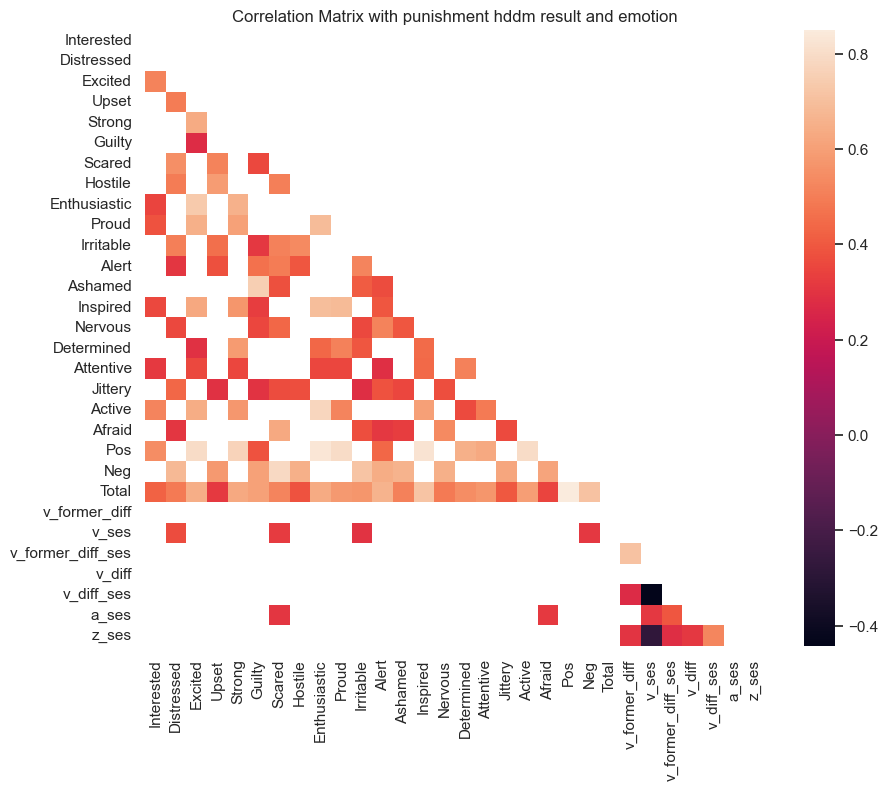

In [47]:
corr = combined_df_punish.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_punish.iloc[:, i], combined_df_punish.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with punishment hddm result and emotion')
plt.show()

In [48]:
p_value_matrix_p = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_p = p_value_matrix_p.applymap(lambda x: round(x, 4))
corr_value_p = combined_df_punish.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_22216\2316489347.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_p = p_value_matrix_p.applymap(lambda x: round(x, 4))


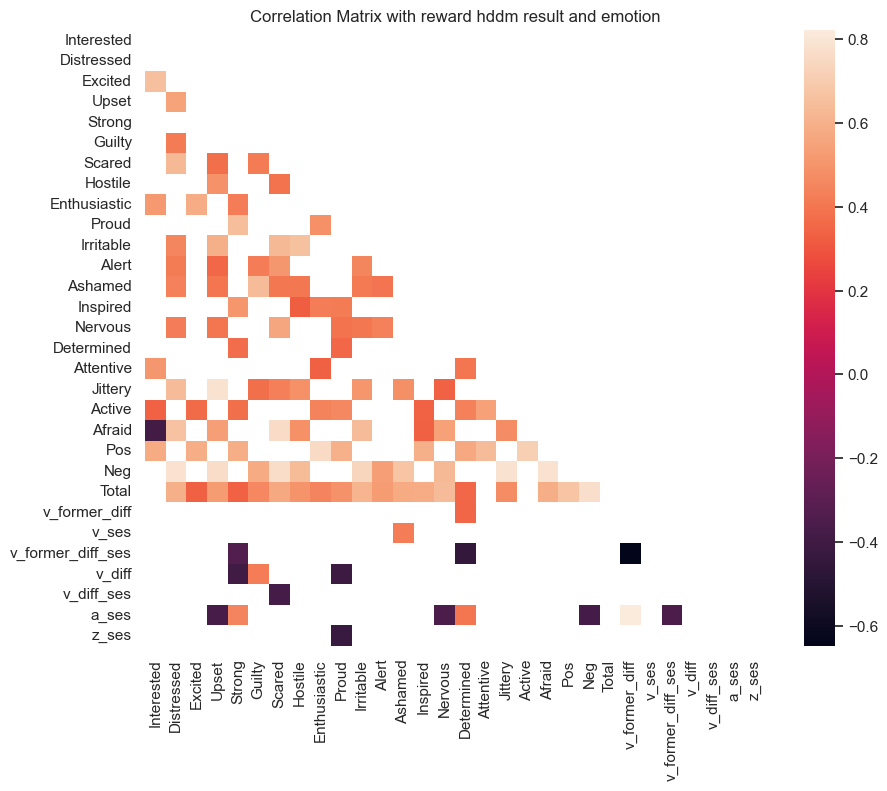

In [49]:
corr = combined_df_reward.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_reward.iloc[:, i], combined_df_reward.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with reward hddm result and emotion')
plt.show()

In [50]:
p_value_matrix_r = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_r = p_value_matrix_r.applymap(lambda x: round(x, 4))
corr_value_r = combined_df_reward.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_22216\3292015793.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_r = p_value_matrix_r.applymap(lambda x: round(x, 4))


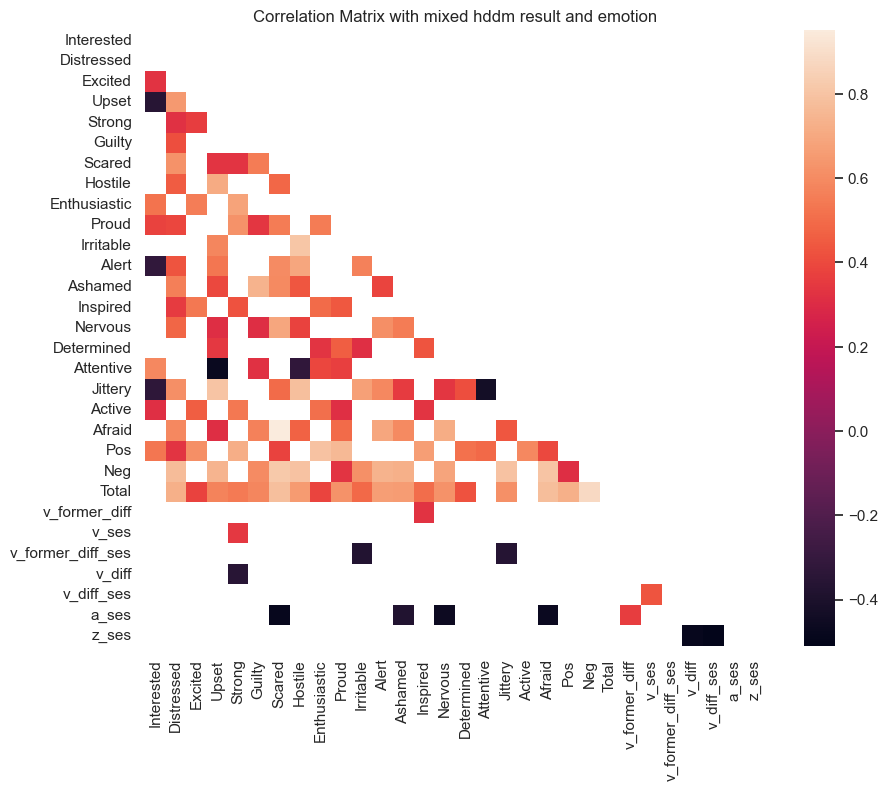

In [51]:
corr = combined_df_mixed.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_mixed.iloc[:, i], combined_df_mixed.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with mixed hddm result and emotion')
plt.show()

In [52]:
p_value_matrix_m = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_m = p_value_matrix_m.applymap(lambda x: round(x, 4))
corr_value_m = combined_df_mixed.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_22216\877543574.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_m = p_value_matrix_m.applymap(lambda x: round(x, 4))


In [53]:
file_path = "hddm_pvalue.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_pvalue_r.to_excel(writer, sheet_name='reward', index=False)
    df_pvalue_p.to_excel(writer, sheet_name='punish', index=False)
    df_pvalue_m.to_excel(writer, sheet_name='mixed', index=False)

In [54]:
file_path = "hddm_corr_value.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    corr_value_r.to_excel(writer, sheet_name='reward', index=False)
    corr_value_p.to_excel(writer, sheet_name='punish', index=False)
    corr_value_m.to_excel(writer, sheet_name='mixed', index=False)

Calculate the correlation between the emotion and the hddm parameters.

In [13]:
color_list = ['#70309f','#e7b13e','#2a74a3','#c66236','#00FFFF']
emotion_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Positive_Sum','Negative_Sum','Total']

坐立不安的
v_ses
坐立不安的
0.00596257058148935
0.3662218004665884


<Figure size 800x600 with 0 Axes>

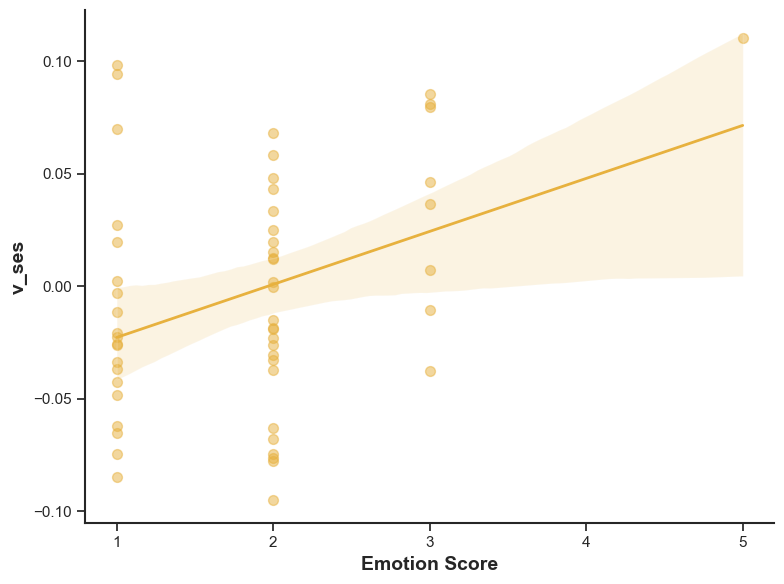

惊恐的
v_ses
惊恐的
0.016054155287785726
0.32330619714607245


<Figure size 800x600 with 0 Axes>

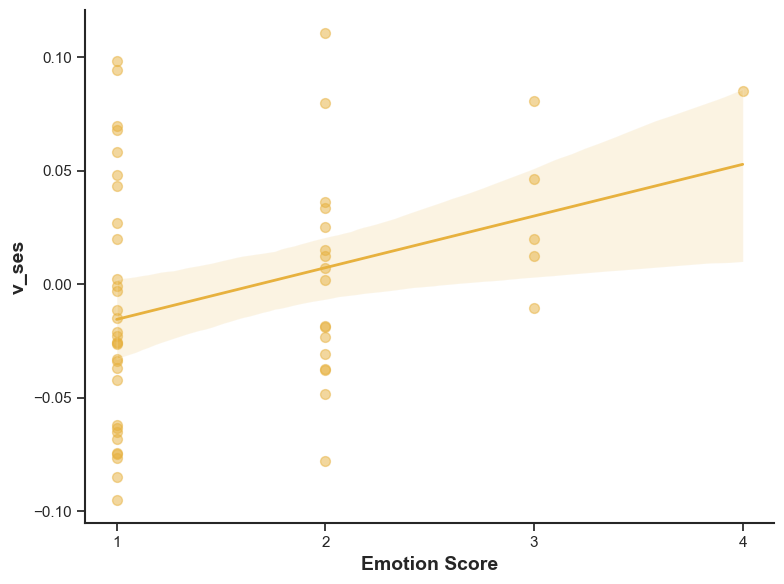

易怒的
v_ses
易怒的
0.027597077885456265
0.29712868001270903


<Figure size 800x600 with 0 Axes>

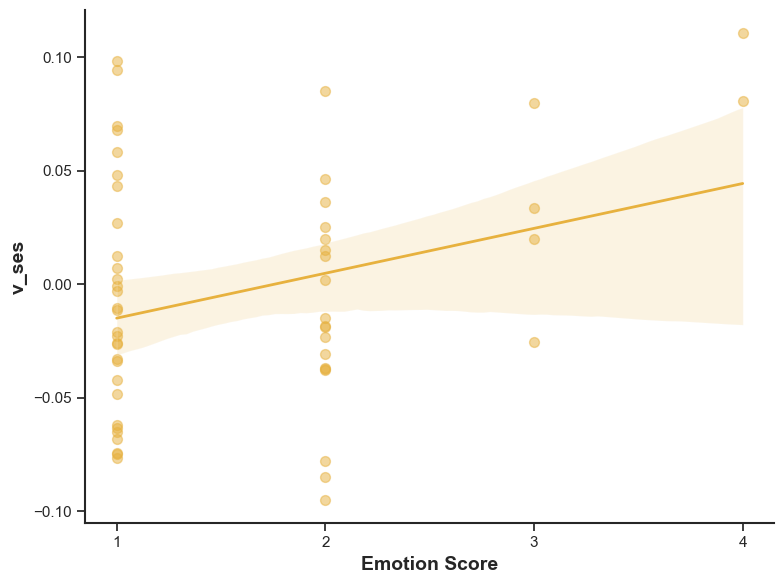

PANAS_Negative affect
v_ses
PANAS_Negative affect
0.0207458038749424
0.31118932229169755


<Figure size 800x600 with 0 Axes>

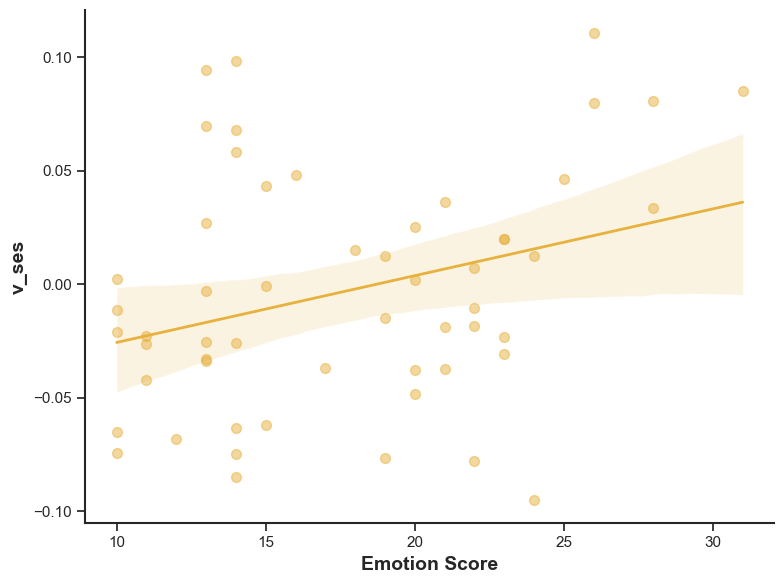

惊恐的
a_ses
惊恐的
0.021869018758681195
0.3086384916376699


<Figure size 800x600 with 0 Axes>

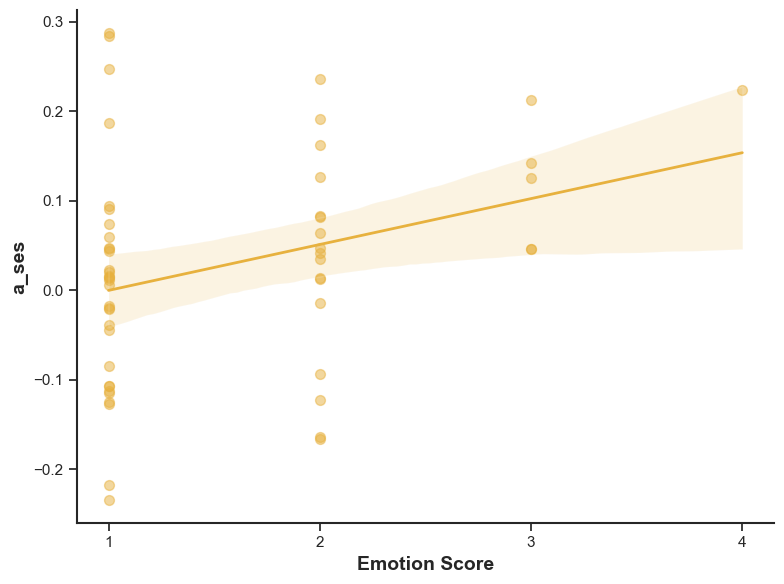

害怕的
a_ses
害怕的
0.017665058445081275
0.31884113234744726


<Figure size 800x600 with 0 Axes>

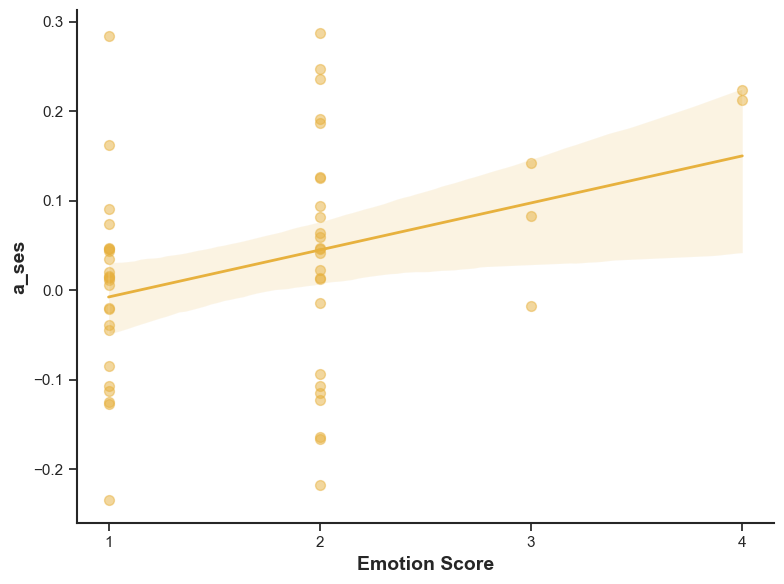

In [14]:
#punishment
my_dict_R = {}
my_dict_p = {}


Total_dict = {}
for jj in range(7):
    emo = -1
    col = -1
    Single_dict = {}
    hddm_para = hddm_para_punish[parameter_list[jj]].values
    
    for ii in punish_emotion_list:
        emo += 1
        col_nn = col_name_list_p[ii]
        score = np.ones([len(sub_list_punishment),1])
        ord = -1 
        for sub in sub_list_punishment:
            ord = ord + 1 
            sub_sc = df_punish[df_punish['被试编号（请询问主试）'] == sub][col_nn]
            
            score[ord] = sub_sc

        
            
        slope, intercept, r, p, stderr = stats.linregress(score.squeeze(), hddm_para) 
        if p < 0.05:
            print(col_nn)
            print(parameter_list[jj])
            print(col_nn)
            print(p)
            print(r)
            col = col + 1
            temp = pd.DataFrame({emotion_list[emo]: score.squeeze(), parameter_list[jj]:  hddm_para})

            # Theme and settings
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(8, 6))

            # Regression plot
            sns.set_theme(style="white")  # Change from "whitegrid" to "white"
            plt.figure(figsize=(8, 6))
            ax = plt.gca()  # Get the current axis

            # Regression plot
            sns.regplot(x=emotion_list[emo], 
                        y=parameter_list[jj], 
                        data=temp, 
                        ci=95,
                        scatter_kws={'s': 50, 'color':  '#e7b13e', 'alpha': 0.5}, 
                        line_kws={'color': '#e7b13e', 'lw': 2},
                        ax=ax)  # Specify the axis for the plot
            
            
            

            # Axes labels, title, and ticks
            ax.set_xlabel('Emotion Score', fontsize=14,weight='bold')
            ax.set_ylabel(parameter_list[jj], fontsize=14,weight='bold')
            if np.max(score.squeeze()) == 5:
                ax.set_xticks([1, 2, 3, 4, 5])
                ax.set_xticklabels([1, 2, 3, 4, 5])
            elif np.max(score.squeeze()) == 4:
                ax.set_xticks([1, 2, 3, 4])
                ax.set_xticklabels([1, 2, 3, 4])
            elif np.max(score.squeeze()) == 3:
                ax.set_xticks([1, 2, 3])
                ax.set_xticklabels([1, 2, 3])
            
            #ax.set_yticks([-8,  -4,  0 ,4 ,8])
            #ax.set_yticklabels([-8,  -4,  0 ,4 ,8])

            # Remove the grid lines
            ax.grid(False)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Set ticks position to left and bottom
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            
            #ax.tick_params(axis='x', direction='in')
            #ax.tick_params(axis='y', direction='in')

            # Show the plot
            plt.tight_layout()
            plt.show()

意志坚定的
v_former_diff
意志坚定的
0.034599623666474934
0.3483694212473283


<Figure size 800x600 with 0 Axes>

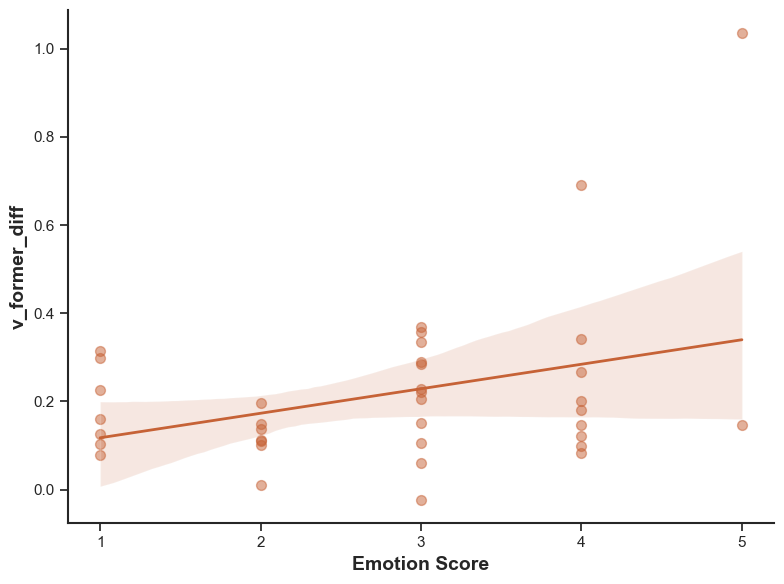

羞愧的
v_ses
羞愧的
0.008629335697432386
0.4256343339458464


<Figure size 800x600 with 0 Axes>

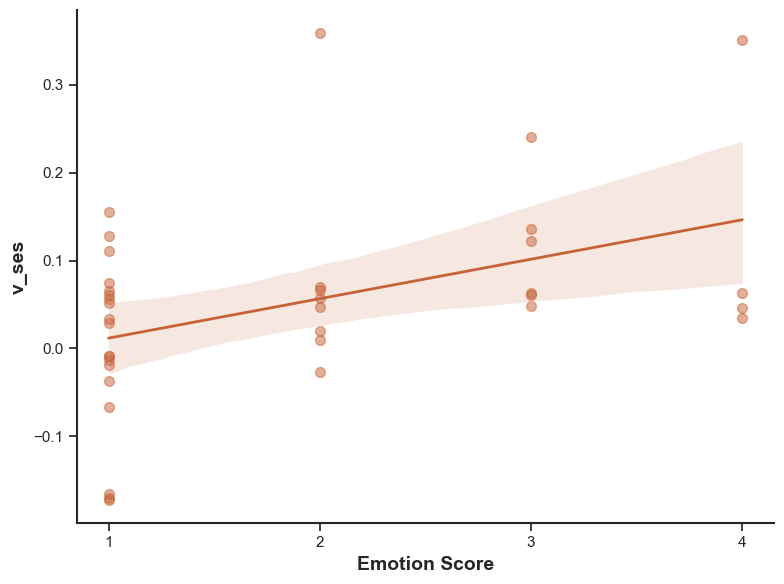

强大的
v_former_diff_ses
强大的
0.04457539600623
-0.33217622306260153


<Figure size 800x600 with 0 Axes>

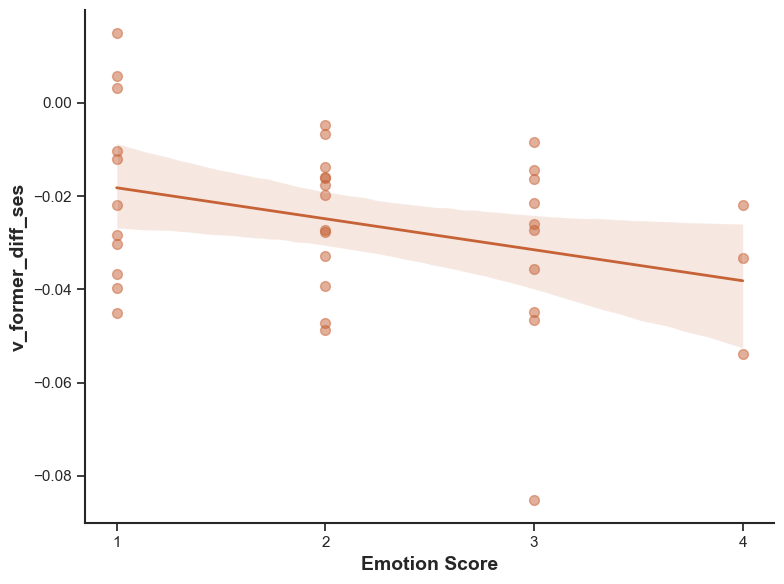

意志坚定的
v_former_diff_ses
意志坚定的
0.005013106549002567
-0.4516719259156025


<Figure size 800x600 with 0 Axes>

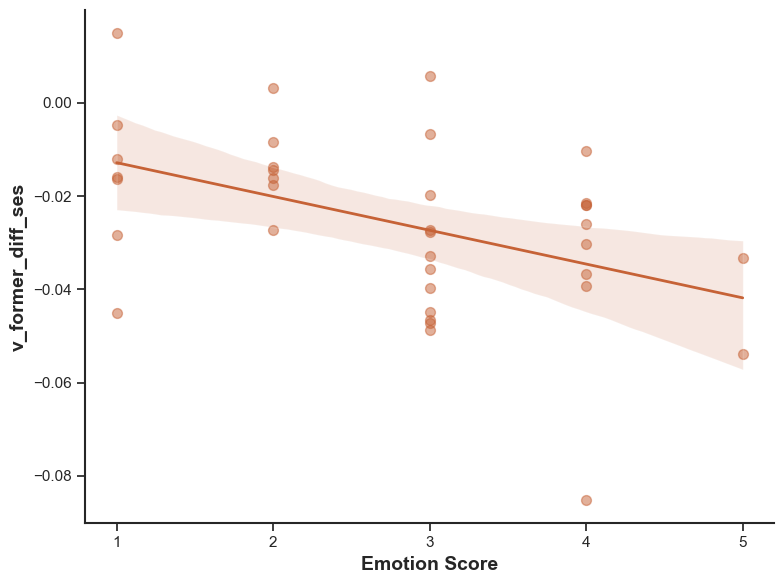

强大的
v_diff
强大的
0.015405993071673441
-0.39547330292428295


<Figure size 800x600 with 0 Axes>

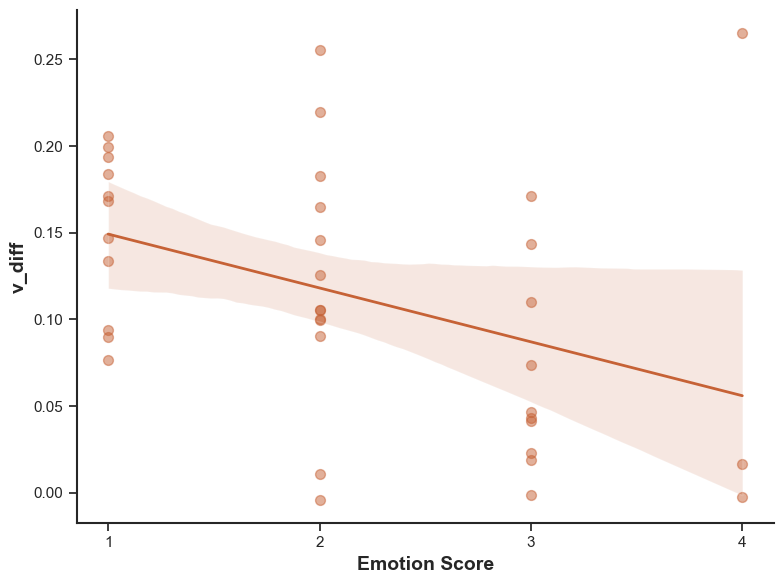

内疚的
v_diff
内疚的
0.00889021645517514
0.42414742445223136


<Figure size 800x600 with 0 Axes>

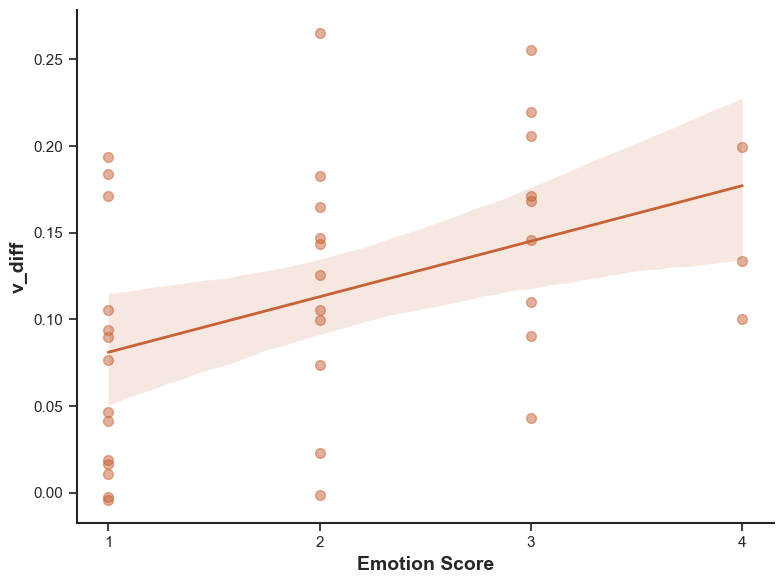

自豪的
v_diff
自豪的
0.011056693479887778
-0.4130587439886317


<Figure size 800x600 with 0 Axes>

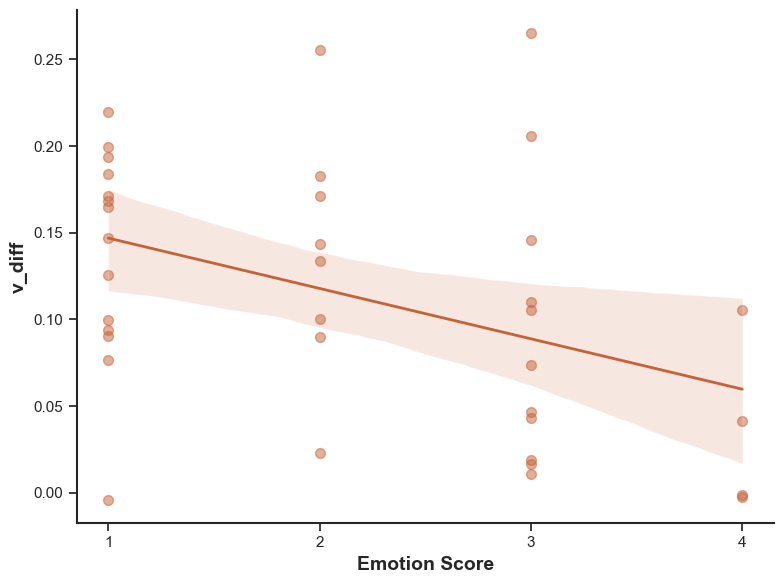

惊恐的
v_diff_ses
惊恐的
0.020093541493586404
-0.3807107091292007


<Figure size 800x600 with 0 Axes>

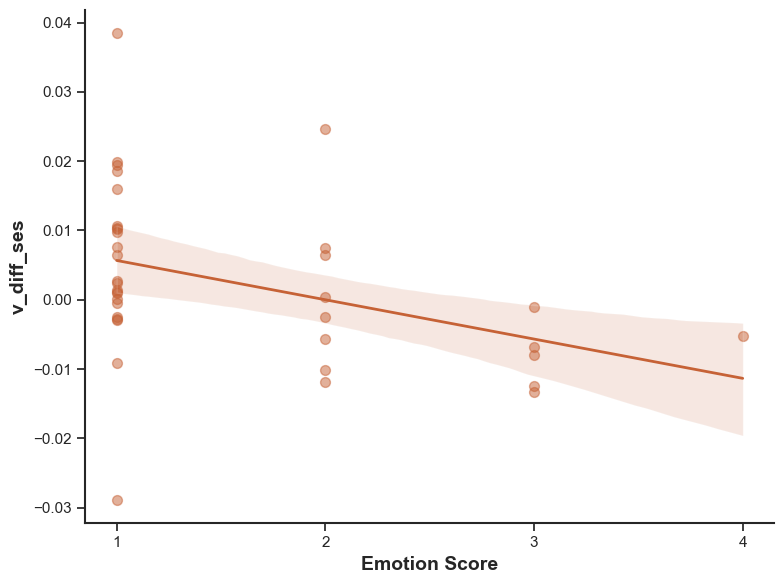

心烦的
a_ses
心烦的
0.024410489012143932
-0.36947709131223433


<Figure size 800x600 with 0 Axes>

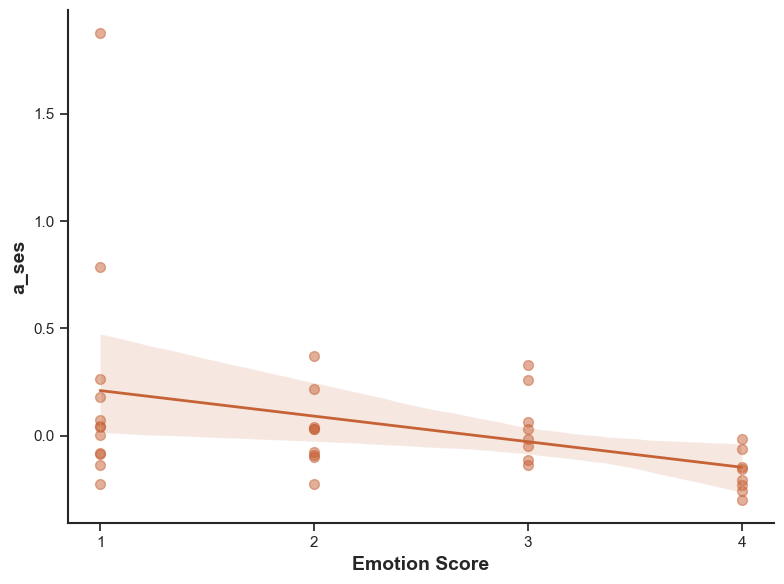

强大的
a_ses
强大的
0.005867676122483418
0.4443280457697432


<Figure size 800x600 with 0 Axes>

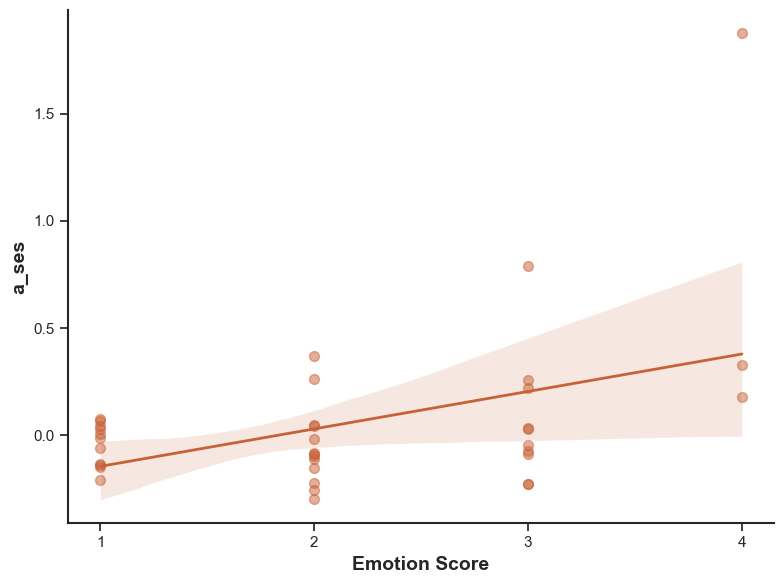

紧张的
a_ses
紧张的
0.02940895017062749
-0.3583674485624802


<Figure size 800x600 with 0 Axes>

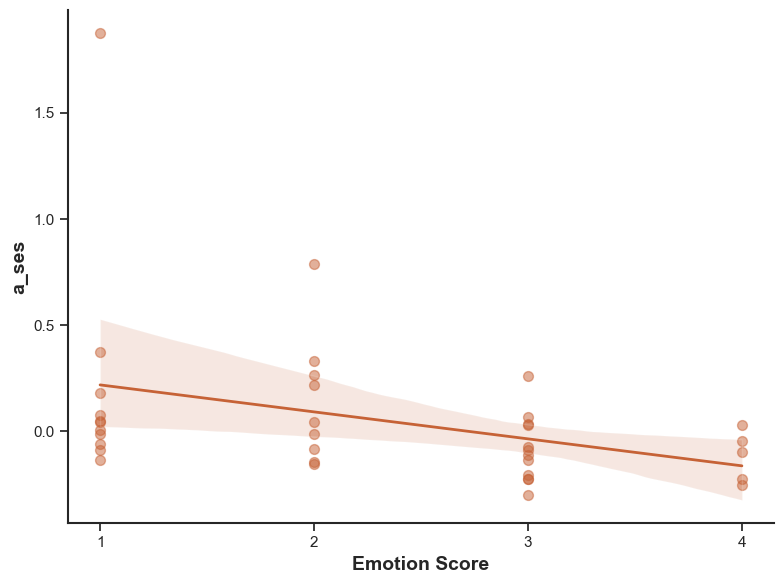

意志坚定的
a_ses
意志坚定的
0.014151749706338148
0.4000615986419564


<Figure size 800x600 with 0 Axes>

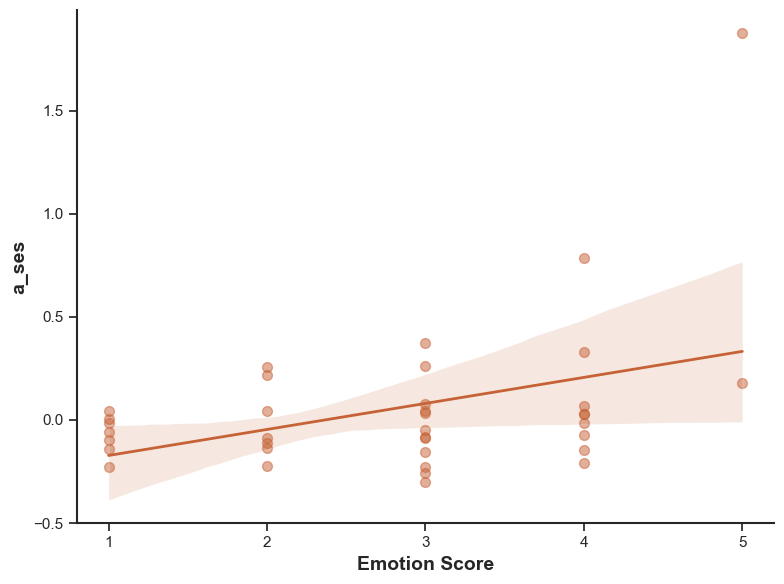

PANAS_Negative affect
a_ses
PANAS_Negative affect
0.01948492212277675
-0.38245288899633456


<Figure size 800x600 with 0 Axes>

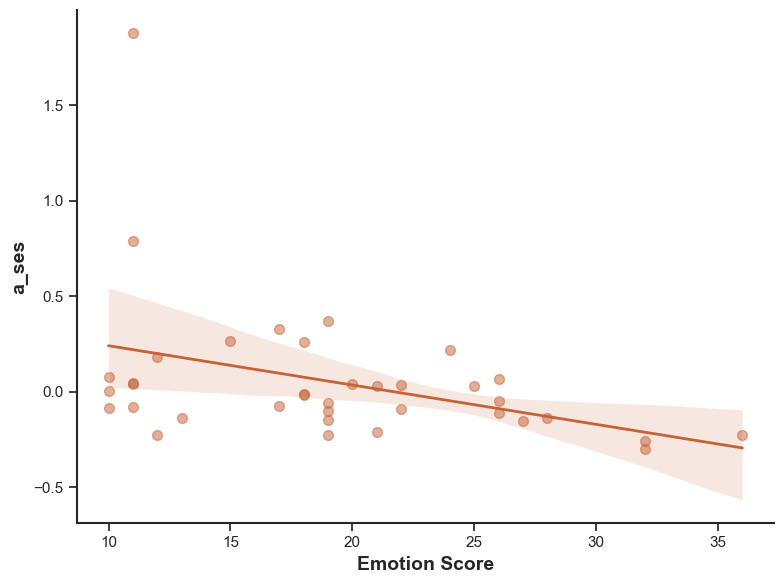

自豪的
z_ses
自豪的
0.007997542290061006
-0.429401134305521


<Figure size 800x600 with 0 Axes>

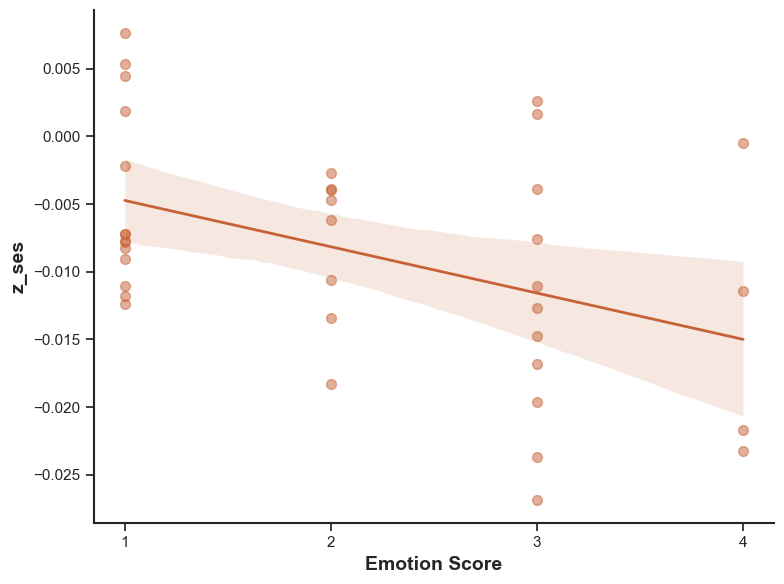

In [14]:
#reward
my_dict_R = {}
my_dict_p = {}


Total_dict = {}
for jj in range(7):
    emo = -1
    col = -1
    Single_dict = {}
    hddm_para = hddm_para_reward[parameter_list[jj]].values
    
    for ii in reward_emotion_list:
        emo += 1
        col_nn = col_name_list_r[ii]
        score = np.ones([len(sub_list_reward),1])
        ord = -1 
        for sub in sub_list_reward:
            ord = ord + 1 
            sub_sc = df_reward[df_reward['被试编号（请询问主试）'] == sub][col_nn]
            
            score[ord] = sub_sc

        
            
        slope, intercept, r, p, stderr = stats.linregress(score.squeeze(), hddm_para) 
        if p < 0.05:
            print(col_nn)
            print(parameter_list[jj])
            print(col_nn)
            print(p)
            print(r)
            col = col + 1
            temp = pd.DataFrame({emotion_list[emo]: score.squeeze(), parameter_list[jj]:  hddm_para})

            # Theme and settings
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(8, 6))

            # Regression plot
            sns.set_theme(style="white")  # Change from "whitegrid" to "white"
            plt.figure(figsize=(8, 6))
            ax = plt.gca()  # Get the current axis

            # Regression plot
            sns.regplot(x=emotion_list[emo], 
                        y=parameter_list[jj], 
                        data=temp, 
                        ci=95,
                        scatter_kws={'s': 50, 'color':  '#c66236', 'alpha': 0.5}, 
                        line_kws={'color': '#c66236', 'lw': 2},
                        ax=ax)  # Specify the axis for the plot
            
            
            

            # Axes labels, title, and ticks
            ax.set_xlabel('Emotion Score', fontsize=14,weight='bold')
            ax.set_ylabel(parameter_list[jj], fontsize=14,weight='bold')
            if np.max(score.squeeze()) == 5:
                ax.set_xticks([1, 2, 3, 4, 5])
                ax.set_xticklabels([1, 2, 3, 4, 5])
            elif np.max(score.squeeze()) == 4:
                ax.set_xticks([1, 2, 3, 4])
                ax.set_xticklabels([1, 2, 3, 4])
            elif np.max(score.squeeze()) == 3:
                ax.set_xticks([1, 2, 3])
                ax.set_xticklabels([1, 2, 3])
            
            #ax.set_yticks([-8,  -4,  0 ,4 ,8])
            #ax.set_yticklabels([-8,  -4,  0 ,4 ,8])

            # Remove the grid lines
            ax.grid(False)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Set ticks position to left and bottom
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            
            #ax.tick_params(axis='x', direction='in')
            #ax.tick_params(axis='y', direction='in')

            # Show the plot
            plt.tight_layout()
            plt.show()

受鼓舞的
v_former_diff
受鼓舞的
0.039119431002526114
0.3234603651729321


<Figure size 800x600 with 0 Axes>

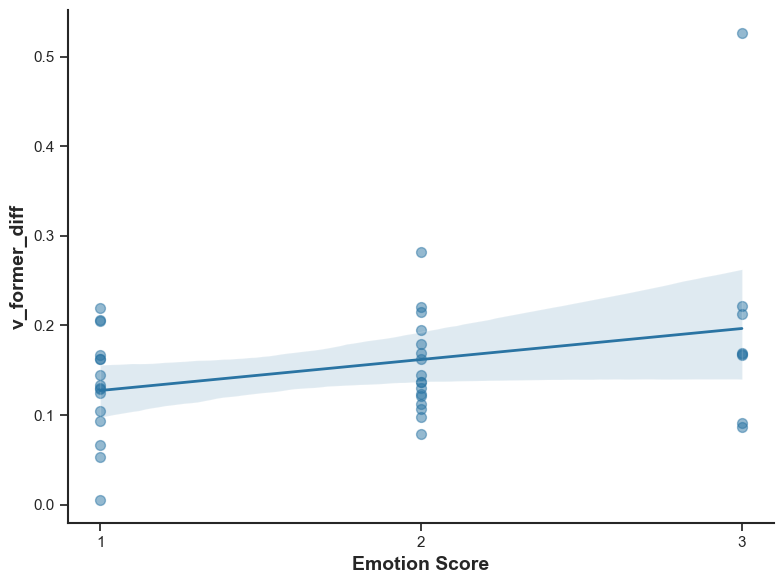

强大的
v_ses
强大的
0.028327750521617952
0.3426017880348448


<Figure size 800x600 with 0 Axes>

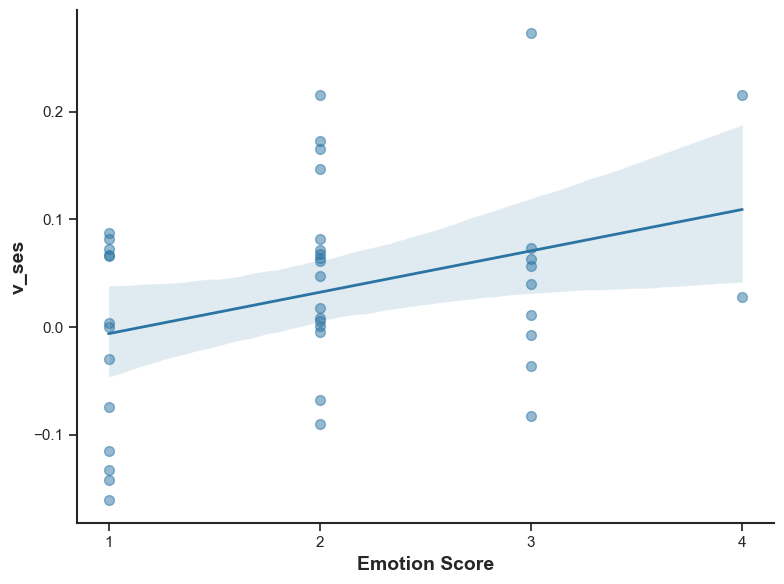

易怒的
v_former_diff_ses
易怒的
0.015173393343922613
-0.3767824182970369


<Figure size 800x600 with 0 Axes>

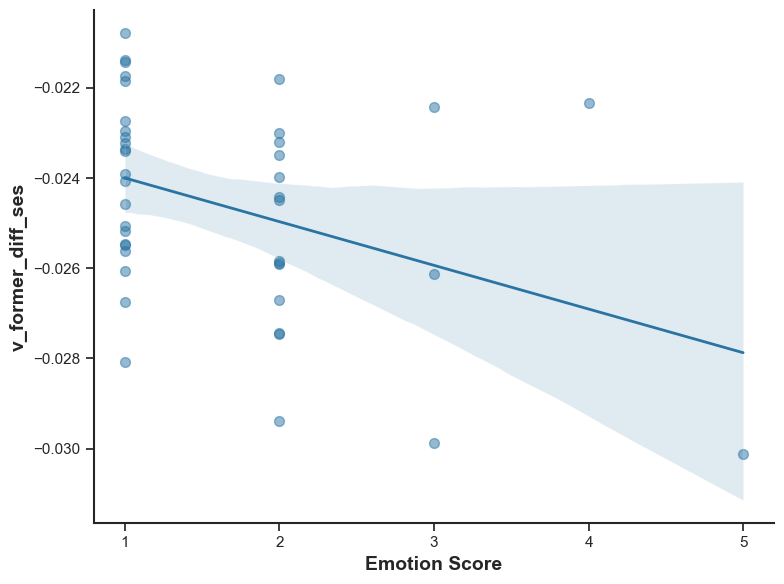

心神不宁的
v_former_diff_ses
心神不宁的
0.019078902236269978
-0.3646416521310259


<Figure size 800x600 with 0 Axes>

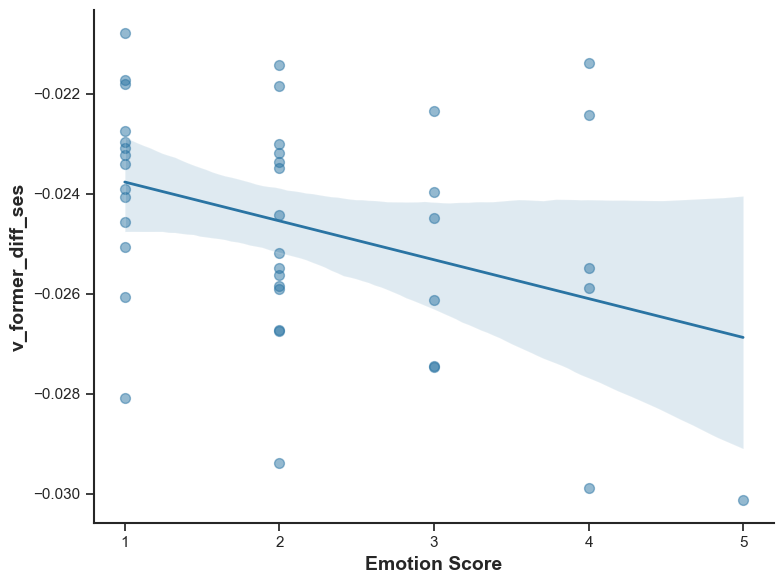

强大的
v_diff
强大的
0.02429048675177105
-0.3513480910499733


<Figure size 800x600 with 0 Axes>

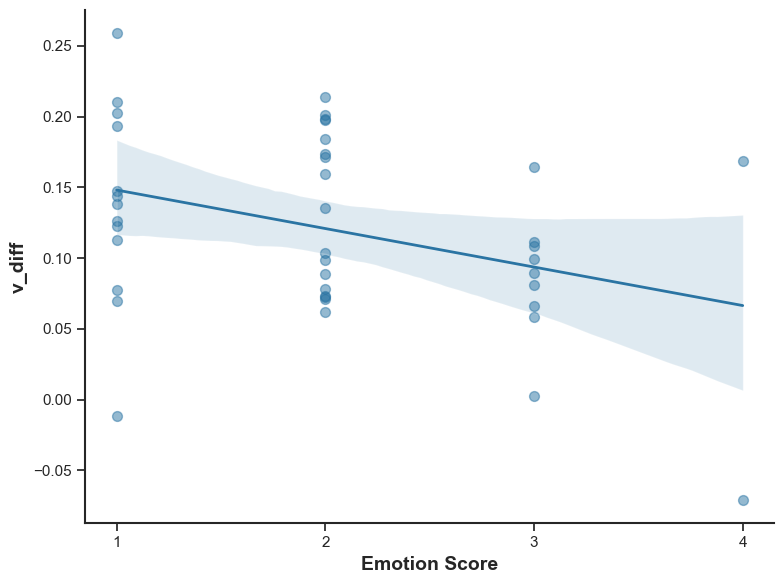

惊恐的
a_ses
惊恐的
0.001378563101626751
-0.48306407088612563


<Figure size 800x600 with 0 Axes>

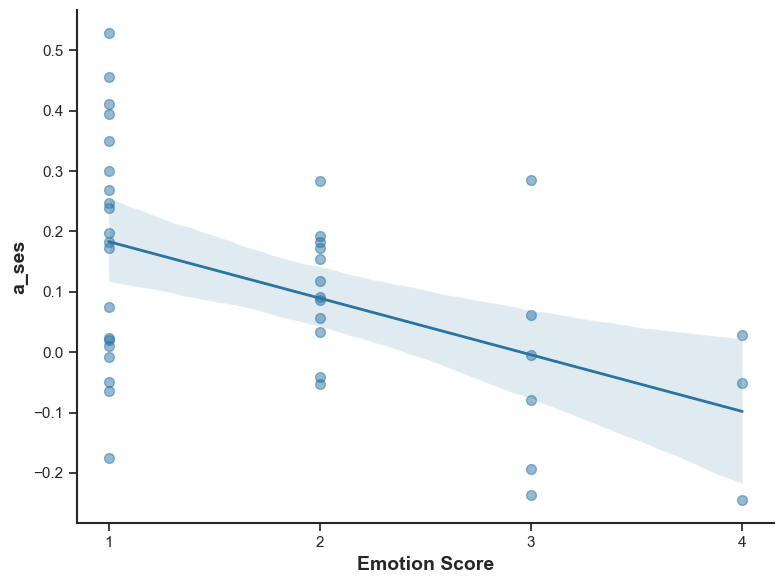

羞愧的
a_ses
羞愧的
0.013724564164704918
-0.3819675619059351


<Figure size 800x600 with 0 Axes>

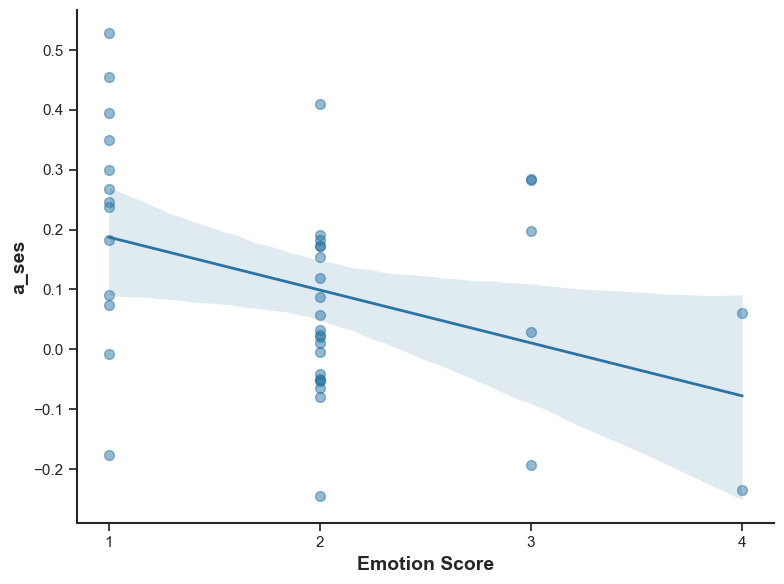

紧张的
a_ses
紧张的
0.002315554830383473
-0.462754890690056


<Figure size 800x600 with 0 Axes>

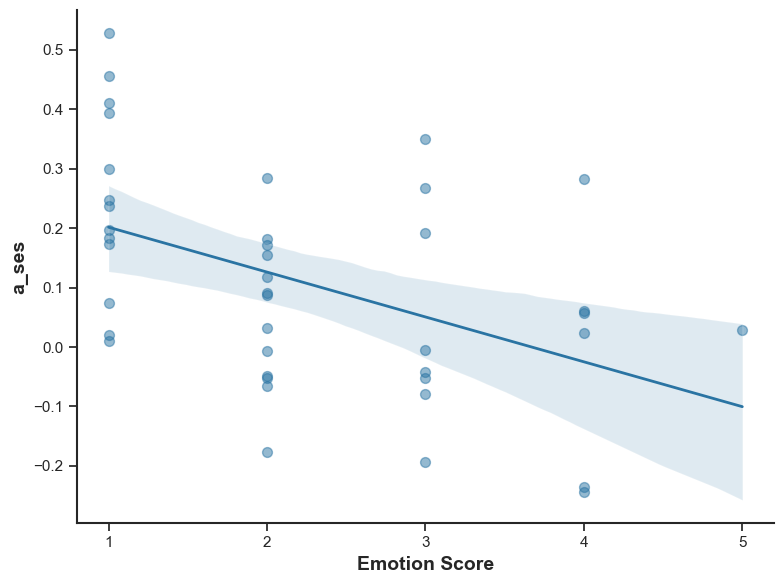

害怕的
a_ses
害怕的
0.0021762977298578914
-0.4652497522995469


<Figure size 800x600 with 0 Axes>

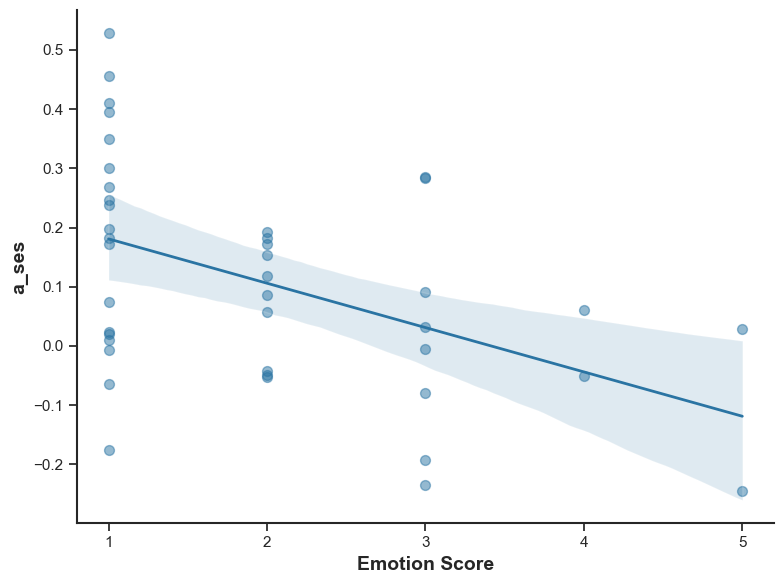

In [13]:
#mixed
my_dict_R = {}
my_dict_p = {}


Total_dict = {}
for jj in range(7):
    emo = -1
    col = -1
    Single_dict = {}
    hddm_para = hddm_para_mixed[parameter_list[jj]].values
    
    for ii in mixed_emotion_list:
        emo += 1
        col_nn = col_name_list_m[ii]
        score = np.ones([len(sub_list_mixed),1])
        ord = -1 
        for sub in sub_list_mixed:
            ord = ord + 1 
            sub_sc = df_mixed[df_mixed['被试编号（请询问主试）'] == sub][col_nn]
            
            score[ord] = sub_sc

        
            
        slope, intercept, r, p, stderr = stats.linregress(score.squeeze(), hddm_para) 
        if p < 0.05:
            print(col_nn)
            print(parameter_list[jj])
            print(col_nn)
            print(p)
            print(r)
            col = col + 1
            temp = pd.DataFrame({emotion_list[emo]: score.squeeze(), parameter_list[jj]:  hddm_para})

            # Theme and settings
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(8, 6))

            # Regression plot
            sns.set_theme(style="white")  # Change from "whitegrid" to "white"
            plt.figure(figsize=(8, 6))
            ax = plt.gca()  # Get the current axis

            # Regression plot
            sns.regplot(x=emotion_list[emo], 
                        y=parameter_list[jj], 
                        data=temp, 
                        ci=95,
                        scatter_kws={'s': 50, 'color':  '#2a74a3', 'alpha': 0.5}, 
                        line_kws={'color': '#2a74a3', 'lw': 2},
                        ax=ax)  # Specify the axis for the plot
            
            
            

            # Axes labels, title, and ticks
            ax.set_xlabel('Emotion Score', fontsize=14,weight='bold')
            ax.set_ylabel(parameter_list[jj], fontsize=14,weight='bold')
            if np.max(score.squeeze()) == 5:
                ax.set_xticks([1, 2, 3, 4, 5])
                ax.set_xticklabels([1, 2, 3, 4, 5])
            elif np.max(score.squeeze()) == 4:
                ax.set_xticks([1, 2, 3, 4])
                ax.set_xticklabels([1, 2, 3, 4])
            elif np.max(score.squeeze()) == 3:
                ax.set_xticks([1, 2, 3])
                ax.set_xticklabels([1, 2, 3])
            
            #ax.set_yticks([-8,  -4,  0 ,4 ,8])
            #ax.set_yticklabels([-8,  -4,  0 ,4 ,8])

            # Remove the grid lines
            ax.grid(False)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Set ticks position to left and bottom
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            
            #ax.tick_params(axis='x', direction='in')
            #ax.tick_params(axis='y', direction='in')

            # Show the plot
            plt.tight_layout()
            plt.show()
        
        